In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

#create DataFrames with the values coming from the trees
file_tau = uproot.open('../../bc_jpsi_tau_nu_gen_v2.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('../../bc_jpsi_mu_nu_gen_v2.root')
tree_mu = file_mu['tree;2']
mu  = tree_mu.pandas.df(tree_mu.keys())

In [3]:
############################################
### ADD NECESSARY FEATURES TO DATAFRAMES ###
############################################


#add the column target to both dataframes
mu ['target'] = 0
tau['target'] = 1
#add the columns of interesting features (taken from LHCb paper)
mu['m2_miss'] = 0 #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
tau['m2_miss'] = 0
mu['muE_Brf'] = 0 #mu energy in the Bc rest frame
tau['muE_Brf'] = 0
mu['q2'] = 0 #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
tau['q2'] = 0
mu['pT_miss'] = 0 #missing transverse momentum (p_B - p_mu1 - p_mu2 - p_mu).Pt
tau['pT_miss'] = 0

bc_vect = ROOT.TLorentzVector()
jpsi_vect = ROOT.TLorentzVector()
mu_vect = ROOT.TLorentzVector()
mu1_vect = ROOT.TLorentzVector()
mu2_vect = ROOT.TLorentzVector()
mu_mass = 0.10565837 #GeV/c^2
jpsi_mass = 3.096900 #GeV/c^2
bc_mass = 6.2756 #GeV/c^2
c = 2.99e8 #m/s

PV = ROOT.TVector3()
SV = ROOT.TVector3()
bc_dir_vect = ROOT.TVector3()
reco_vect = ROOT.TLorentzVector()

# in the following, when creating the TLorentzVector of mu, mu1, mu2 we try to account for the reconstruction error
# made by the tracker and the muon system in the value of pT
# we include a gaussian smearing -> we draw a value of pT from a gaussian centered at the value of the MC pT of the
#                                   muon and with sigma 7% of the value of the MC pT (CMS performance)
start = time.time()
i = 0
while i < mu['run'].count(): 
    # set the reconstructed particles 4vectors considering the smearing in the measure of pT due to the 
    # experimental setup (considered to be 7% as a mean between the 1-1.5% at 10GeV and the 6-17% at 1TeV)
    mu_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu_pt'], mu.at[i,'mu_pt']*7/100),0),mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu1_pt'], mu.at[i,'mu1_pt']*7/100),0),mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu2_pt'], mu.at[i,'mu2_pt']*7/100),0),mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)

    # set the PV and SV and calculate primary-secondary vertex distance
    # include smearing of PV reconstruction with a gaussian smearing taken from a CMS paper
    # include smearing of SV reconstruction with a gaussian smearing with sigma double of the PV one
    PV.SetXYZ(np.random.normal(mu.at[i,'pv_x'], 20*1e-6),np.random.normal(mu.at[i,'pv_y'], 20*1e-6),np.random.normal(mu.at[i,'pv_z'], 30*1e-6))
    SV.SetXYZ(np.random.normal(mu.at[i,'sv_x'], 40*1e-6),np.random.normal(mu.at[i,'sv_y'], 40*1e-6),np.random.normal(mu.at[i,'sv_z'], 60*1e-6))
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    
    '''
    # setting the above 4vectors and verteces without the smearing (un-comment it if needed)
    mu_vect.SetPtEtaPhiM(mu.at[i,'mu_pt'],mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(mu.at[i,'mu1_pt'],mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(mu.at[i,'mu2_pt'],mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)
    PV.SetXYZ(mu.at[i,'pv_x'], mu.at[i,'pv_y'], mu.at[i,'pv_z'])
    SV.SetXYZ(mu.at[i,'sv_x'], mu.at[i,'sv_y'], mu.at[i,'sv_z'])
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    '''
    
    reco_vect = mu_vect + mu1_vect + mu2_vect
    
    # reconstruct the pT of the Bc and set the 4vector
    bc_pZreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pz()
    bc_pXreco = bc_pZreco*(SV.X()-PV.X())/(SV.Z() - PV.Z())
    bc_pYreco = bc_pZreco*(SV.Y()-PV.Y())/(PV.Z()-SV.Z())
    bc_Preco = bc_pZreco * dist_PSV / ((SV.Z() - PV.Z())*1e-2)
    bc_vect.SetPtEtaPhiM(np.sqrt(bc_pXreco**2+bc_pYreco**2),mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],bc_mass)
    
    #######
    # test using the reconstruction of pT instead of pZ (gives slightly different results) 
    #bc_pTreco = mu.at[i,'bc_mass'] * reco_vect.Pt() / reco_vect.Mag() 
    #bc_vect.SetPtEtaPhiM(mu.at[i,'bc_mass']*reco_vect.Pt()/reco_vect.Mag(),mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],mu.at[i,'bc_mass'])
    #######
    
    m2_vect = bc_vect - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vect - mu1_vect - mu2_vect
    
    mu.at[i,'m2_miss'] = m2_vect.Mag2()
    mu.at[i,'q2'] = q2_vect.Mag2()
    mu.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity())
    mu.at[i,'pT_miss'] = m2_vect.Pt()
    
    # decay length and time
    mu.at[i,'bc_DL'] = dist_PSV
    mu.at[i,'bc_CT'] = dist_PSV / (bc_vect.Gamma()*bc_vect.Beta())                     
    
    # we look for the best roconstruction of the jpsi 
    muons = [mu_vect,mu1_vect,mu2_vect]
    muons_charge = [mu.at[i,'mu_charge'],mu.at[i,'mu1_charge'],mu.at[i,'mu2_charge']]
    pair_vect = ROOT.TLorentzVector()
    if muons_charge[0] != muons_charge[1]:
        pair1_vect = muons[0] + muons[1]
        pair2_vect = muons[1] + muons[2]
    else:
        pair1_vect = muons[0] + muons[2]
        pair2_vect = muons[1] + muons[2]
     
    if (abs(pair1_vect.Mag() - jpsi_mass)) < abs((pair2_vect.Mag() - jpsi_mass)):
        mu.at[i,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
    else:
        mu.at[i,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
    
    i += 1

                               
i = 0
while i < tau['run'].count():
    # set the reconstructed particles 4vectors considering the smearing in the measure of pT due to the 
    # experimental setup (considered to be 7% as a mean between the 1-1.5% at 10GeV and the 6-17% at 1TeV)
    mu_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu_pt'], tau.at[i,'mu_pt']*7/100),0),tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu1_pt'], tau.at[i,'mu1_pt']*7/100),0),tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu2_pt'], tau.at[i,'mu2_pt']*7/100),0),tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)

    # set the PV and SV and calculate primary-secondary vertex distance
    # include smearing of PV reconstruction with a gaussian smearing taken from a CMS paper
    # include smearing of SV reconstruction with a gaussian smearing with sigma double of the PV one
    PV.SetXYZ(np.random.normal(tau.at[i,'pv_x'], 20*1e-6),np.random.normal(tau.at[i,'pv_y'], 20*1e-6),np.random.normal(tau.at[i,'pv_z'], 30*1e-6))
    SV.SetXYZ(np.random.normal(tau.at[i,'sv_x'], 40*1e-6),np.random.normal(tau.at[i,'sv_y'], 40*1e-6),np.random.normal(tau.at[i,'sv_z'], 60*1e-6))
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    
    '''
    # setting the above 4vectors and verteces without the smearing (un-comment it if needed)
    mu_vect.SetPtEtaPhiM(tau.at[i,'mu_pt'],tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(tau.at[i,'mu1_pt'],tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(tau.at[i,'mu2_pt'],tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)
    PV.SetXYZ(tau.at[i,'pv_x'], tau.at[i,'pv_y'], tau.at[i,'pv_z'])
    SV.SetXYZ(tau.at[i,'sv_x'], tau.at[i,'sv_y'], tau.at[i,'sv_z'])
    dist_PSV = np.sqrt((PV.X()-SV.X())**2+(PV.Y()-SV.Y())**2+(PV.Z()-SV.Z())**2)*1e-2
    '''
    
    reco_vect = mu_vect + mu1_vect + mu2_vect
    
    # reconstruct the pT of the Bc and set the 4vector
    bc_pZreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pz()
    bc_pXreco = bc_pZreco*(SV.X()-PV.X())/(SV.Z() - PV.Z())
    bc_pYreco = bc_pZreco*(SV.Y()-PV.Y())/(PV.Z()-SV.Z())
    bc_Preco = bc_pZreco * dist_PSV / ((SV.Z() - PV.Z())*1e-2)
    bc_vect.SetPtEtaPhiM(np.sqrt(bc_pXreco**2+bc_pYreco**2),tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],bc_mass)
    
    ########
    # test using the reconstruction of pT instead of pZ (gives slightly different results) 
    #bc_pTreco = (tau.at[i,'bc_mass'] / reco_vect.Mag()) * reco_vect.Pt()
    #bc_vect.SetPtEtaPhiM(bc_pTreco,tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],tau.at[i,'bc_mass'])
    ########
    
    m2_vect = bc_vect - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vect - mu1_vect - mu2_vect
    
    tau.at[i,'m2_miss'] = m2_vect.Mag2()
    tau.at[i,'q2'] = q2_vect.Mag2()
    tau.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity())
    tau.at[i,'pT_miss'] = m2_vect.Pt()
    
    # decay length and decay time(c*tau)
    tau.at[i,'bc_DL'] = dist_PSV
    tau.at[i,'bc_CT'] = dist_PSV / (bc_vect.Gamma()*bc_vect.Beta())
                          
    # we look for the best roconstruction of the jpsi 
    muons = [mu_vect,mu1_vect,mu2_vect]
    muons_charge = [mu.at[i,'mu_charge'],mu.at[i,'mu1_charge'],mu.at[i,'mu2_charge']]
    pair_vect = ROOT.TLorentzVector()
    if muons_charge[0] != muons_charge[1]:
        pair1_vect = muons[0] + muons[1]
        pair2_vect = muons[1] + muons[2]
    else:
        pair1_vect = muons[0] + muons[2]
        pair2_vect = muons[1] + muons[2]
     
    if (abs(pair1_vect.Mag() - jpsi_mass)) < (abs(pair2_vect.Mag() - jpsi_mass)):
        tau.at[i,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
    else:
        tau.at[i,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
    
    i += 1
    
end = time.time()
print 'Running time to add the new vars to the df = %.1f'%(end - start)

Running time to add the new vars to the df = 1383.6


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 71766 samples, validate on 71767 samples
Epoch 1/10
71766/71766 [==============================] - 10s 146us/step - loss: 0.3466 - acc: 0.8650 - val_loss: 0.3324 - val_acc: 0.8637
Epoch 2/10
71766/71766 [==============================] - 10s 142us/step - loss: 0.3256 - acc: 0.8697 - val_loss: 0.3218 - val_acc: 0.8701 - los
Epoch 3/10
71766/71766 [==============================] - 10s 137us/step - loss: 0.3212 - acc: 0.8704 - val_loss: 0.3155 - val_acc: 0.8719
Epoch 4/10
71766/71766 [==============================] - 10s 138us/step - loss: 0.3174 - acc: 0.8709 - val_loss: 0.3117 - val_acc: 0.8728
Epoch 5/10
71766/71766 [==============================] - 10s 142us/step - loss: 0.3143 - acc: 0.8718 - val_loss: 0.3091 - val_acc: 0.8736
Epoch 6/10
71766/71766 [==============================] - 10s 144us/step - loss: 0.3133 - acc: 0.8724 - val_loss: 0.3079 - val_ac

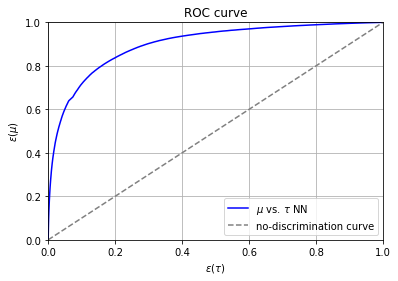

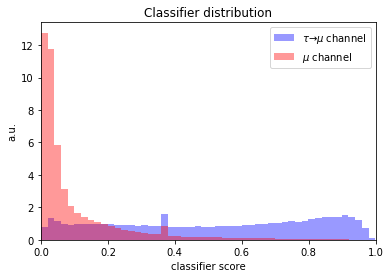

AUC = 0.8992244700937251
Gini index = 0.7984489401874502


2019-07-03 17:34:50.277512: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


<Figure size 432x288 with 0 Axes>

In [4]:
############################################################################
### TRAINING AND TESTING OF THE NN WITHOUTH THE VARIABLE WE WANT TO TEST ### 
############################################################################



### PREPARE DFs FOR TRAINING AND TEST ###

#these features are taken from the LHCb paper and have to be computed and added to the dataframes
features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2', #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)
    #'pT_miss',
    #'bc_DL', #decay length of the Bc
    #'bc_CT', #c*tau of teh Bc
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    #'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    #'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    #'mu2_charge',
]

# concatenate the two samples
dataset = pd.concat([mu, tau],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])



### DEFINE THE MODEL ###

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### TRAIN THE MODEL ###

# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)



### TEST THE TRAINING OF THE MODEL ###

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)



### ROC & SCORE CURVES ###

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('roc_no_test.pdf')
plt.show()
#plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.savefig('score_no_test.pdf')
plt.show()
plt.clf()

# compute the auc
auroc1 = auc(fpr, tpr)
print "AUC =", auroc1 

# compute Gini index
print "Gini index =", (auroc1-0.5)*2

Train on 71766 samples, validate on 71767 samples
Epoch 1/10
71766/71766 [==============================] - 11s 148us/step - loss: 0.3592 - acc: 0.8590 - val_loss: 0.3197 - val_acc: 0.8735
Epoch 2/10
71766/71766 [==============================] - 10s 143us/step - loss: 0.3233 - acc: 0.8729 - val_loss: 0.3206 - val_acc: 0.8742
Epoch 3/10
71766/71766 [==============================] - 10s 143us/step - loss: 0.3160 - acc: 0.8737 - val_loss: 0.3181 - val_acc: 0.8752
Epoch 4/10
71766/71766 [==============================] - 10s 145us/step - loss: 0.3127 - acc: 0.8752 - val_loss: 0.3046 - val_acc: 0.8754
Epoch 5/10
71766/71766 [==============================] - 10s 143us/step - loss: 0.3074 - acc: 0.8756 - val_loss: 0.3136 - val_acc: 0.8721
Epoch 6/10
71766/71766 [==============================] - 10s 142us/step - loss: 0.3060 - acc: 0.8748 - val_loss: 0.3018 - val_acc: 0.8761
Epoch 7/10
71766/71766 [==============================] - 10s 143us/step - loss: 0.3040 - acc: 0.8756 - val_loss: 0.

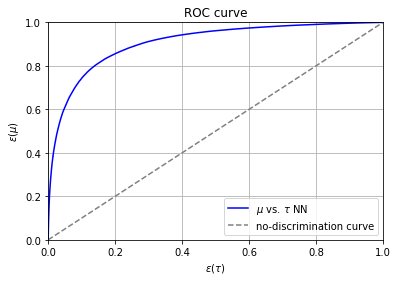

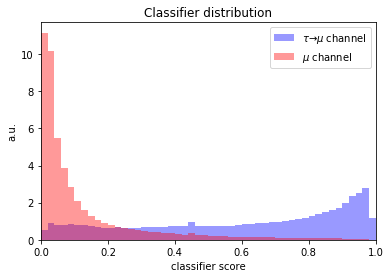

AUC = 0.9065643464113231
Gini index = 0.8131286928226462


<Figure size 432x288 with 0 Axes>

In [5]:
########################################################################
### TRAINING AND TESTING OF THE NN WITH THE VARIABLE WE WANT TO TEST ### 
########################################################################



### PREPARE DFs FOR TRAINING AND TEST ###

#these features are taken from the LHCb paper and have to be computed and added to the dataframes
features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2', #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)
    'pT_miss',
    #'bc_DL', #decay length of the Bc
    #'bc_CT', #c*tau of teh Bc
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    #'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    #'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    #'mu2_charge',
]

# concatenate the two samples
dataset = pd.concat([mu, tau],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])



### DEFINE THE MODEL ###

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### TRAIN THE MODEL ###

# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)



### TEST THE TRAINING OF THE MODEL ###

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)



### ROC & SCORE CURVES ###

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('roc_test.pdf')
plt.show()
plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.savefig('score_test.pdf')
plt.show()
plt.clf()

# compute the auc
auroc2 = auc(fpr, tpr)
print "AUC =", auroc2 

# compute Gini index
print "Gini index =", (auroc2-0.5)*2

In [6]:
print "AUC without test variable =", auroc1 
print "Gini index without test variable =", (auroc1-0.5)*2
print "\nAUC with test variable =", auroc2 
print "Gini index with test variable =", (auroc2-0.5)*2

AUC without test variable = 0.8992244700937251
Gini index without test variable = 0.7984489401874502

AUC with test variable = 0.9065643464113231
Gini index with test variable = 0.8131286928226462


In [7]:
#corr_test = pd.DataFrame(mu, columns=['q2','muE_Brf','pT_miss'])
#print corr_test.corr()